<a href="https://colab.research.google.com/github/MarcosDiorio/Processo-Seletivo-de-Estagio-em-Inteligencia-Artificial/blob/main/Processo_Seletivo_de_Est%C3%A1gio_em_Intelig%C3%AAncia_Artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Análise de Reviews E-commerce Olist - Classificação de Sentimento

**Autor:** Marcos Diorio

**Data:** Setembro 2025  

**Projeto:** Desafio Bravium - Estágio em Inteligência Artificial  

## 🎯 Objetivo
Desenvolver um modelo de classificação capaz de identificar se uma review de produto é **POSITIVA** ou **NEGATIVA**, além de extrair as razões por trás da classificação.

## 📊 Dataset
- **Fonte:** [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)
- **Contexto:** Reviews de clientes do marketplace brasileiro Olist

# 🚀 PARTE 1: SETUP INICIAL E CONFIGURAÇÃO

In [ ]:
!pip install -q wordcloud textblob xgboost plotly

# Imports essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
from datetime import datetime
import pickle
import re
from collections import Counter

# Processamento de texto
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords # Import stopwords module

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            roc_auc_score, classification_report, confusion_matrix, roc_curve)
from sklearn.decomposition import LatentDirichletAllocation
import xgboost as xgb

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Baixar recursos do NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Load and update Portuguese stopwords
stopwords_pt = set(stopwords.words('portuguese')) # Load Portuguese stopwords and convert to a set
stopwords_pt.update([
    "o", "a", "os", "as", "e", "é", "ja", "de", "da", "do", "em",
    "um", "uma", "com", "pra", "pro", "na", "no","O", "A", "OS", "AS", "E", "É", "JA","JÁ", "DE", "DA", "DO", "EM",
    "UM", "UMA", "COM", "PRA", "PRO", "NA", "NO"])

print("📚 Bibliotecas carregadas com sucesso!")
print(f"🕐 Iniciado em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📚 Bibliotecas carregadas com sucesso!
🕐 Iniciado em: 2025-09-30 13:31:23


# 2. CARREGAMENTO DOS DADOS

In [ ]:


def carregar_dados():
    try:
        base_path = '/content/sample_data/'

        files = {
            'reviews': 'olist_order_reviews_dataset.csv',
            'orders': 'olist_orders_dataset.csv',
            'items': 'olist_order_items_dataset.csv',
            'products': 'olist_products_dataset.csv'
        }

        datasets = {}
        for name, filename in files.items():
            try:
                datasets[name] = pd.read_csv(base_path + filename)
                print(f"✅ {name}: {datasets[name].shape[0]:,} linhas, {datasets[name].shape[1]} colunas")
            except FileNotFoundError:
                print(f"⚠️ Arquivo {filename} não encontrado. Continuando sem ele...")
                datasets[name] = None

        if datasets['reviews'] is not None:
            print(f"\n🎉 Dataset principal carregado com sucesso!")
            return datasets['reviews'], datasets['orders'], datasets['items'], datasets['products']
        else:
            raise FileNotFoundError("Dataset principal de reviews não encontrado")

    except Exception as e:
        print(f"❌ Erro ao carregar dados: {e}")
        print("\n💡 Alternativa: Criar dados de exemplo para demonstração")
        return criar_dados_exemplo()


def fazer_upload_arquivo():
    """
    Helper para fazer upload de arquivos no Colab
    """
    from google.colab import files
    print("📂 Selecione o arquivo olist_order_reviews_dataset.csv")
    uploaded = files.upload()
    return uploaded

def criar_dados_exemplo():
    """
    Cria um dataset de exemplo para demonstrar o funcionamento
    """
    print("🧪 Criando dados de exemplo para demonstração...")

    np.random.seed(42)
    n_samples = 1000

    # Reviews de exemplo em português
    reviews_positivas = [
        "Produto excelente, chegou rápido e bem embalado",
        "Adorei a compra, superou minhas expectativas",
        "Qualidade muito boa, recomendo",
        "Entrega rápida, produto conforme descrição",
        "Ótimo custo benefício, muito satisfeito",
        "Produto perfeito, vendedor muito atencioso",
        "Chegou antes do prazo, bem protegido",
        "Excelente qualidade, voltarei a comprar"
    ]

    reviews_negativas = [
        "Produto chegou quebrado, péssima experiência",
        "Demorou muito para entregar, produto ruim",
        "Não funcionou, qualidade terrível",
        "Veio diferente da descrição, decepcionante",
        "Atendimento péssimo, produto com defeito",
        "Não recomendo, perda de tempo e dinheiro",
        "Produto de baixa qualidade, não vale",
        "Embalagem péssima, produto danificado"
    ]

    reviews_neutras = [
        "Produto ok, nada demais",
        "Atendeu as expectativas básicas",
        "Produto razoável pelo preço",
        "Normal, sem grandes surpresas",
        "Adequado para o que precisava",
        "Produto comum, nada especial"
    ]

    # Gerar dataset
    data = []
    for i in range(n_samples):
        score = np.random.choice([1, 2, 3, 4, 5], p=[0.1, 0.1, 0.2, 0.3, 0.3])

        if score <= 2:
            review_text = np.random.choice(reviews_negativas)
        elif score >= 4:
            review_text = np.random.choice(reviews_positivas)
        else:
            review_text = np.random.choice(reviews_neutras)

        data.append({
            'review_id': f'review_{i:04d}',
            'order_id': f'order_{i:04d}',
            'review_score': score,
            'review_comment_message': review_text if np.random.random() > 0.2 else np.nan,
            'review_creation_date': '2023-01-01'
        })

    df_reviews = pd.DataFrame(data)
    print(f"📊 Dataset de exemplo criado: {len(df_reviews)} reviews")
    return df_reviews, None, None, None

# Carregar dados
print("🔄 Tentando carregar dados...")
df_reviews, df_orders, df_items, df_products = carregar_dados()

🔄 Tentando carregar dados...
⚠️ Arquivo olist_order_reviews_dataset.csv não encontrado. Continuando sem ele...
⚠️ Arquivo olist_orders_dataset.csv não encontrado. Continuando sem ele...
⚠️ Arquivo olist_order_items_dataset.csv não encontrado. Continuando sem ele...
⚠️ Arquivo olist_products_dataset.csv não encontrado. Continuando sem ele...
❌ Erro ao carregar dados: Dataset principal de reviews não encontrado

💡 Alternativa: Criar dados de exemplo para demonstração
🧪 Criando dados de exemplo para demonstração...
📊 Dataset de exemplo criado: 1000 reviews


# 🔍 PARTE 2: ANÁLISE EXPLORATÓRIA DOS DADOS  

🔍 ANÁLISE EXPLORATÓRIA - DATASET DE REVIEWS

📋 INFORMAÇÕES BÁSICAS:
• Shape: (1000, 5)
• Reviews únicas: 1000
• Pedidos únicos: 1000

📊 COLUNAS E TIPOS:
• review_id: object
• order_id: object
• review_score: int64
• review_comment_message: object
• review_creation_date: object

🕳️ VALORES MISSING:
• review_comment_message: 231 (23.1%)

👀 AMOSTRA DOS DADOS:


,review_id,order_id,review_score,review_comment_message,review_creation_date
0,review_0000,order_0000,3,NaN,2023-01-01
1,review_0001,order_0001,5,NaN,2023-01-01
2,review_0002,order_0002,2,"Não funcionou, qualidade terrível",2023-01-01
3,review_0003,order_0003,3,NaN,2023-01-01
4,review_0004,order_0004,5,"Entrega rápida, produto conforme descrição",2023-01-01



⭐ ANÁLISE DAS NOTAS DE REVIEW

📈 ESTATÍSTICAS DAS NOTAS:
count    1000.000000
mean        3.589000
std         1.256845
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: review_score, dtype: float64

📊 DISTRIBUIÇÃO DAS NOTAS:
• Nota 1: 92 (9.2%)
• Nota 2: 103 (10.3%)
• Nota 3: 218 (21.8%)
• Nota 4: 298 (29.8%)
• Nota 5: 289 (28.9%)


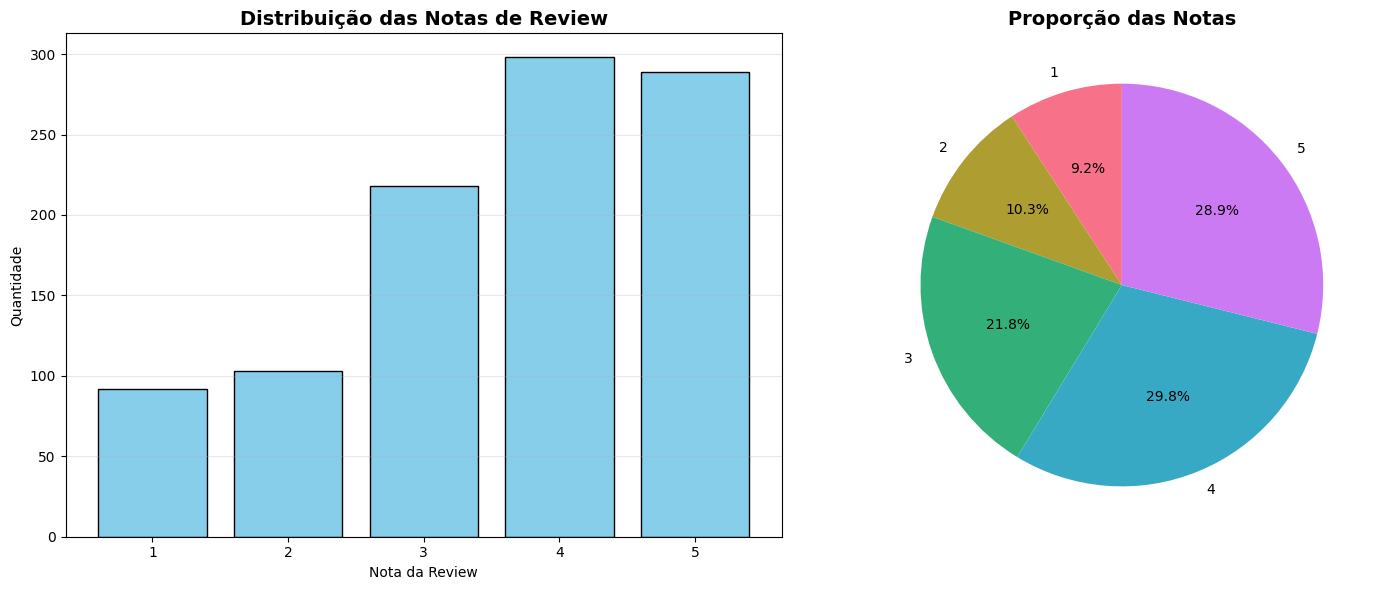


🎯 CRIAÇÃO DA VARIÁVEL ALVO
📋 Critério utilizado: score 1-2 = Negativa, 3 = Neutra, 4-5 = Positiva

📊 DISTRIBUIÇÃO DA VARIÁVEL ALVO:
• Positiva: 587 (58.7%)
• Neutra: 218 (21.8%)
• Negativa: 195 (19.5%)


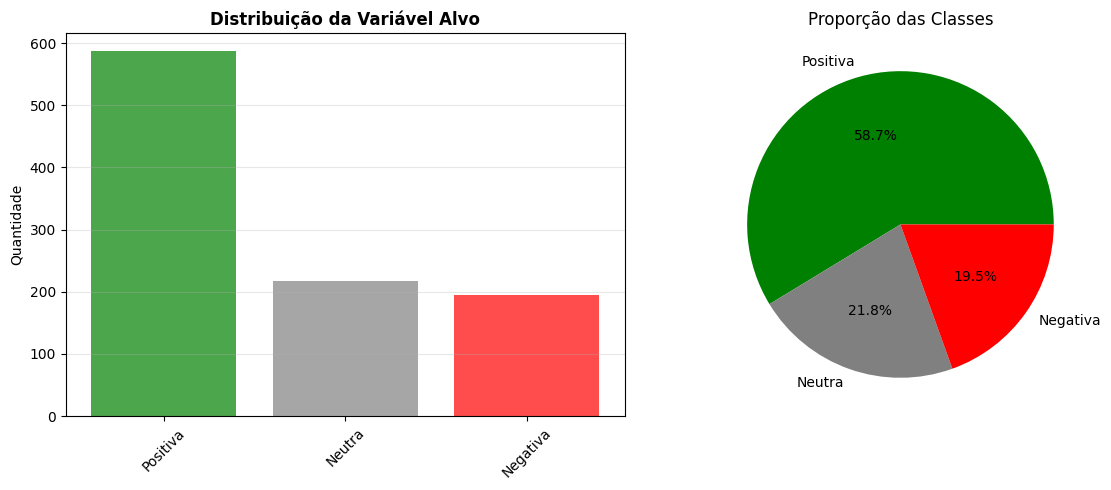


✅ Variável alvo criada com sucesso!


In [ ]:
def explorar_dataset(df):
    """
    Realiza análise exploratória inicial
    """
    print("=" * 60)
    print("🔍 ANÁLISE EXPLORATÓRIA - DATASET DE REVIEWS")
    print("=" * 60)

    # Informações básicas
    print(f"\n📋 INFORMAÇÕES BÁSICAS:")
    print(f"• Shape: {df.shape}")
    print(f"• Reviews únicas: {df['review_id'].nunique()}")
    if 'order_id' in df.columns:
        print(f"• Pedidos únicos: {df['order_id'].nunique()}")

    # Colunas e tipos
    print(f"\n📊 COLUNAS E TIPOS:")
    for col in df.columns:
        print(f"• {col}: {df[col].dtype}")

    # Valores missing
    print(f"\n🕳️ VALORES MISSING:")
    missing = df.isnull().sum()
    for col, count in missing.items():
        if count > 0:
            pct = (count / len(df)) * 100
            print(f"• {col}: {count:,} ({pct:.1f}%)")

    # Primeiras linhas
    print(f"\n👀 AMOSTRA DOS DADOS:")
    display(df.head())

    return df

def analisar_review_scores(df):
    """
    Analisa a distribuição das notas de review
    """
    print("\n" + "=" * 50)
    print("⭐ ANÁLISE DAS NOTAS DE REVIEW")
    print("=" * 50)

    # Estatísticas básicas
    print(f"\n📈 ESTATÍSTICAS DAS NOTAS:")
    print(df['review_score'].describe())

    # Distribuição das notas
    score_dist = df['review_score'].value_counts().sort_index()
    print(f"\n📊 DISTRIBUIÇÃO DAS NOTAS:")
    for score, count in score_dist.items():
        pct = (count / len(df)) * 100
        print(f"• Nota {score}: {count:,} ({pct:.1f}%)")

    # Visualização
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Gráfico de barras
    ax1.bar(score_dist.index, score_dist.values, color='skyblue', edgecolor='black')
    ax1.set_title('Distribuição das Notas de Review', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Nota da Review')
    ax1.set_ylabel('Quantidade')
    ax1.grid(axis='y', alpha=0.3)

    # Gráfico de pizza
    ax2.pie(score_dist.values, labels=score_dist.index, autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette("husl", len(score_dist)))
    ax2.set_title('Proporção das Notas', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return score_dist

# Executar análise exploratória
if df_reviews is not None:
    df_reviews = explorar_dataset(df_reviews)
    score_distribution = analisar_review_scores(df_reviews)

# ============================================================================
# 🎯 CRIAÇÃO DA VARIÁVEL ALVO
# ============================================================================

def criar_variavel_alvo(df, criterio='score_based'):
    """
    Cria a variável alvo (positiva/negativa) baseada em diferentes critérios
    """
    print("\n" + "=" * 50)
    print("🎯 CRIAÇÃO DA VARIÁVEL ALVO")
    print("=" * 50)

    df_copy = df.copy()

    if criterio == 'score_based':
        # Critério padrão: Negativa (1-2), Neutra (3), Positiva (4-5)
        df_copy['target'] = df_copy['review_score'].apply(
            lambda x: 'Negativa' if x <= 2 else ('Positiva' if x >= 4 else 'Neutra')
        )
        print("📋 Critério utilizado: score 1-2 = Negativa, 3 = Neutra, 4-5 = Positiva")

    elif criterio == 'balanced':
        # Critério balanceado: Negativa (1-3), Positiva (4-5)
        df_copy['target'] = df_copy['review_score'].apply(
            lambda x: 'Negativa' if x <= 3 else 'Positiva'
        )
        print("📋 Critério utilizado: score 1-3 = Negativa, 4-5 = Positiva")

    # Estatísticas da nova variável
    target_dist = df_copy['target'].value_counts()
    print(f"\n📊 DISTRIBUIÇÃO DA VARIÁVEL ALVO:")
    for classe, count in target_dist.items():
        pct = (count / len(df_copy)) * 100
        print(f"• {classe}: {count:,} ({pct:.1f}%)")

    # Visualização
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    colors = {'Negativa': 'red', 'Neutra': 'gray', 'Positiva': 'green'}
    bar_colors = [colors.get(x, 'blue') for x in target_dist.index]
    plt.bar(target_dist.index, target_dist.values, color=bar_colors, alpha=0.7)
    plt.title('Distribuição da Variável Alvo', fontweight='bold')
    plt.ylabel('Quantidade')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.pie(target_dist.values, labels=target_dist.index, autopct='%1.1f%%',
            colors=[colors.get(x, 'blue') for x in target_dist.index])
    plt.title('Proporção das Classes')

    plt.tight_layout()
    plt.show()

    return df_copy, target_dist

# Criar variável alvo
if df_reviews is not None:
    df_with_target, target_distribution = criar_variavel_alvo(df_reviews, 'score_based')
    print(f"\n✅ Variável alvo criada com sucesso!")

#📝 PARTE 3: PREPROCESSAMENTO E ANÁLISE DE TEXTO


🔧 CRIANDO FEATURES DE TEXTO...
✅ Features criadas! Total de colunas: 15

📊 RESUMO DAS FEATURES:
• tem_texto: média = 0.77
• num_caracteres: média = 27.75
• num_palavras: média = 3.87
• palavras_positivas: média = 0.70
• palavras_negativas: média = 0.17
• sentimento_score: média = 0.53

📝 ANÁLISE DE TEXTO POR SENTIMENTO...


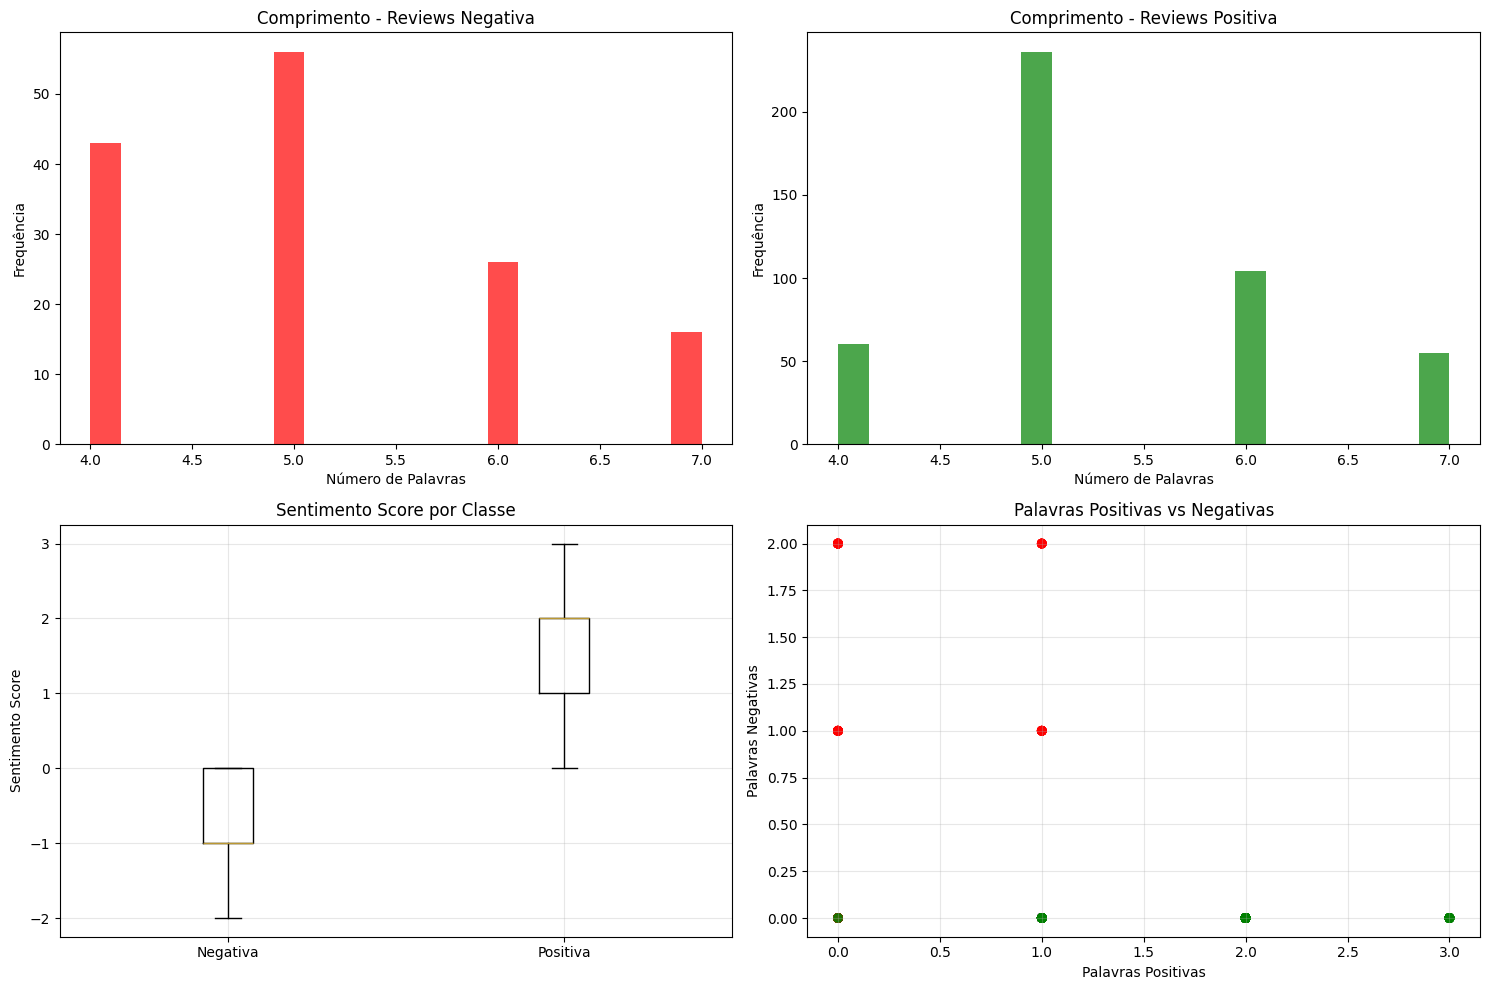

In [ ]:
def preprocessar_texto(texto):
    """
    Função para limpeza e preprocessamento de texto em português
    """
    if pd.isna(texto) or texto == "":
        return ""

    texto = str(texto).lower()
    # Remover caracteres especiais, manter apenas letras, números e espaços
    texto = re.sub(r'[^a-záàâãéèêíïóôõöúçñ\s0-9]', ' ', texto)
    # Remover múltiplos espaços
    texto = re.sub(r'\s+', ' ', texto)
    texto = texto.strip()

    return texto

def criar_features_texto(df):
    """
    Cria features baseadas no texto das reviews
    """
    print("\n🔧 CRIANDO FEATURES DE TEXTO...")

    df_copy = df.copy()

    # Preencher valores nulos
    df_copy['review_comment_message'] = df_copy['review_comment_message'].fillna('')

    # Aplicar preprocessamento
    df_copy['texto_limpo'] = df_copy['review_comment_message'].apply(preprocessar_texto)

    # Features básicas de texto
    df_copy['tem_texto'] = (df_copy['texto_limpo'] != '').astype(int)
    df_copy['num_caracteres'] = df_copy['texto_limpo'].str.len()
    df_copy['num_palavras'] = df_copy['texto_limpo'].str.split().str.len()
    df_copy['num_exclamacao'] = df_copy['review_comment_message'].str.count('!')
    df_copy['num_interrogacao'] = df_copy['review_comment_message'].str.count('\?')

    # Features de palavras-chave
    palavras_positivas = ['bom', 'boa', 'excelente', 'ótimo', 'ótima', 'perfeito', 'perfeita',
                         'recomendo', 'satisfeito', 'rapido', 'rápido', 'qualidade', 'adorei']

    palavras_negativas = ['ruim', 'péssimo', 'péssima', 'terrível', 'horrível', 'demora',
                         'atrasado', 'defeito', 'quebrado', 'insatisfeito', 'decepção', 'não']

    # Contar palavras positivas e negativas
    df_copy['palavras_positivas'] = df_copy['texto_limpo'].apply(
        lambda x: sum(1 for palavra in palavras_positivas if palavra in x)
    )
    df_copy['palavras_negativas'] = df_copy['texto_limpo'].apply(
        lambda x: sum(1 for palavra in palavras_negativas if palavra in x)
    )
    df_copy['sentimento_score'] = df_copy['palavras_positivas'] - df_copy['palavras_negativas']

    print(f"✅ Features criadas! Total de colunas: {df_copy.shape[1]}")

    # Estatísticas das novas features
    print(f"\n📊 RESUMO DAS FEATURES:")
    feature_cols = ['tem_texto', 'num_caracteres', 'num_palavras',
                   'palavras_positivas', 'palavras_negativas', 'sentimento_score']

    for col in feature_cols:
        if col in df_copy.columns:
            print(f"• {col}: média = {df_copy[col].mean():.2f}")

    return df_copy

def analisar_textos_por_sentimento(df):
    """
    Analisa características dos textos por sentimento
    """
    print("\n📝 ANÁLISE DE TEXTO POR SENTIMENTO...")

    # Filtrar apenas reviews com texto
    df_texto = df[df['tem_texto'] == 1].copy()

    if len(df_texto) == 0:
        print("❌ Nenhuma review com texto encontrada")
        return

    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Comprimento por sentimento
    for i, target_class in enumerate(['Negativa', 'Positiva']):
        if target_class in df_texto['target'].values:
            subset = df_texto[df_texto['target'] == target_class]
            if len(subset) > 0:
                axes[0, i].hist(subset['num_palavras'], bins=20, alpha=0.7,
                               color='red' if target_class == 'Negativa' else 'green')
                axes[0, i].set_title(f'Comprimento - Reviews {target_class}')
                axes[0, i].set_xlabel('Número de Palavras')
                axes[0, i].set_ylabel('Frequência')

    # Sentimento score por classe
    df_binary = df_texto[df_texto['target'].isin(['Negativa', 'Positiva'])]
    if len(df_binary) > 0:
        axes[1, 0].boxplot([df_binary[df_binary['target'] == 'Negativa']['sentimento_score'],
                           df_binary[df_binary['target'] == 'Positiva']['sentimento_score']],
                          labels=['Negativa', 'Positiva'])
        axes[1, 0].set_title('Sentimento Score por Classe')
        axes[1, 0].set_ylabel('Sentimento Score')
        axes[1, 0].grid(True, alpha=0.3)

    # Palavras positivas vs negativas
    if len(df_binary) > 0:
        scatter_data = df_binary.sample(min(500, len(df_binary)))
        colors = ['red' if x == 'Negativa' else 'green' for x in scatter_data['target']]
        axes[1, 1].scatter(scatter_data['palavras_positivas'],
                          scatter_data['palavras_negativas'],
                          c=colors, alpha=0.6)
        axes[1, 1].set_xlabel('Palavras Positivas')
        axes[1, 1].set_ylabel('Palavras Negativas')
        axes[1, 1].set_title('Palavras Positivas vs Negativas')
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Aplicar preprocessamento
if df_with_target is not None:
    df_processed = criar_features_texto(df_with_target)
    analisar_textos_por_sentimento(df_processed)

# 🤖 PARTE 4: MODELAGEM DE MACHINE LEARNING


🎯 PREPARANDO DADOS PARA MODELAGEM...
📊 Dataset para modelagem:
• Total de amostras: 782
• Positivas: 587
• Negativas: 195
• Balanceamento: 75.1%
🔤 Criando features TF-IDF com 596 textos...
• Total de features: 131
  - Features numéricas: 8
  - Features TF-IDF: 123

✂️ DIVIDINDO DADOS EM TREINO E TESTE...
📊 Treino: 476 amostras, Teste: 120 amostras

🤖 TREINANDO E COMPARANDO MODELOS...

🔧 Treinando Logistic Regression...
✅ Logistic Regression - F1: 1.000, AUC: 1.000

🔧 Treinando Random Forest...
✅ Random Forest - F1: 1.000, AUC: 1.000

🔧 Treinando XGBoost...
✅ XGBoost - F1: 1.000, AUC: 1.000

📊 COMPARAÇÃO DE MODELOS:
                     accuracy  precision  recall   f1  auc
Logistic Regression       1.0        1.0     1.0  1.0  1.0
Random Forest             1.0        1.0     1.0  1.0  1.0
XGBoost                   1.0        1.0     1.0  1.0  1.0

🏆 MELHOR MODELO: Logistic Regression (F1-Score: 1.000)


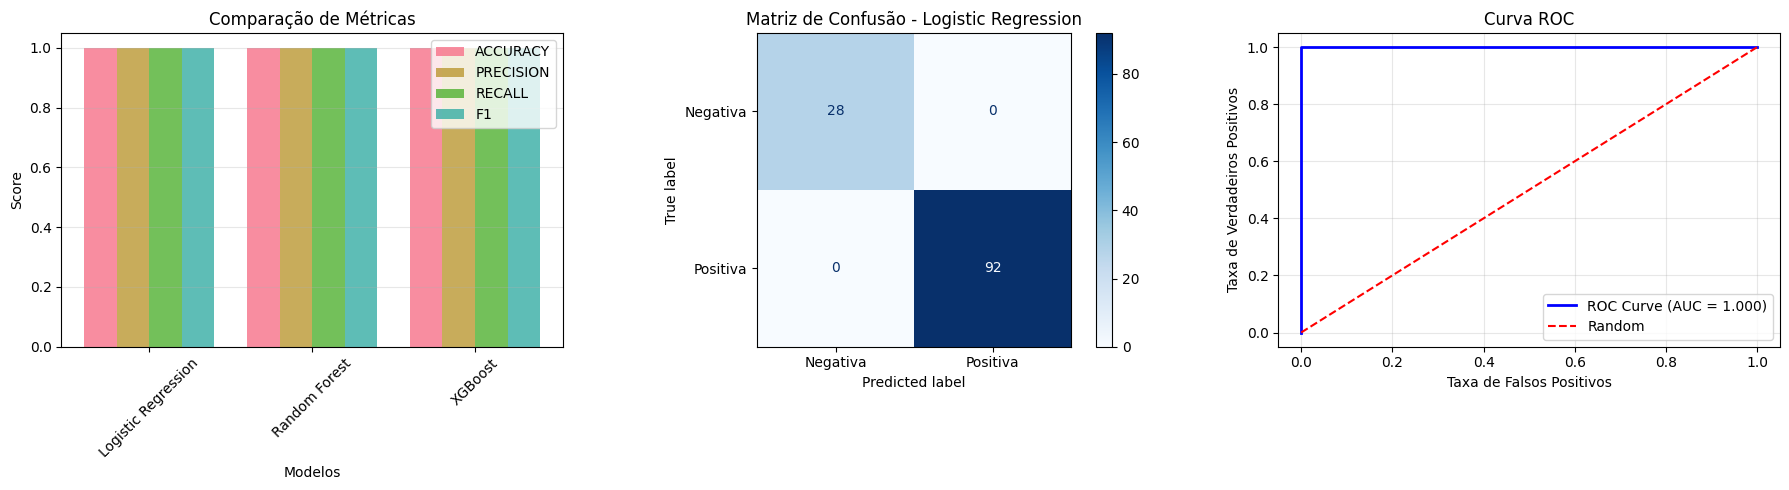

In [ ]:
def preparar_dados_modelagem(df, max_features=1000):
    """
    Prepara os dados finais para modelagem
    """
    print("\n🎯 PREPARANDO DADOS PARA MODELAGEM...")

    # Filtrar apenas classes Positiva e Negativa
    df_binary = df[df['target'].isin(['Positiva', 'Negativa'])].copy()

    # Converter target para numérico
    df_binary['target_numeric'] = (df_binary['target'] == 'Positiva').astype(int)

    print(f"📊 Dataset para modelagem:")
    print(f"• Total de amostras: {len(df_binary):,}")
    print(f"• Positivas: {(df_binary['target_numeric'] == 1).sum():,}")
    print(f"• Negativas: {(df_binary['target_numeric'] == 0).sum():,}")
    print(f"• Balanceamento: {(df_binary['target_numeric'] == 1).mean():.1%}")

    # Features numéricas
    feature_cols = []
    numeric_features = ['review_score', 'num_caracteres', 'num_palavras',
                       'num_exclamacao', 'num_interrogacao',
                       'palavras_positivas', 'palavras_negativas', 'sentimento_score']

    for col in numeric_features:
        if col in df_binary.columns:
            feature_cols.extend([col])

    # Features TF-IDF (apenas se houver textos)
    reviews_com_texto = df_binary[df_binary['tem_texto'] == 1]
    tfidf_features = []

    if len(reviews_com_texto) > 10:  # Só criar TF-IDF se houver textos suficientes
        print(f"🔤 Criando features TF-IDF com {len(reviews_com_texto)} textos...")

        vectorizer = TfidfVectorizer(
            max_features=max_features,
            min_df=2,
            max_df=0.8,
            ngram_range=(1, 2),
            token_pattern=r'\b[a-záàâãéèêíïóôõöúçñ]{2,}\b'
        )

        tfidf_matrix = vectorizer.fit_transform(reviews_com_texto['texto_limpo'])
        tfidf_feature_names = [f'tfidf_{name}' for name in vectorizer.get_feature_names_out()]

        # Criar DataFrame TF-IDF
        tfidf_df = pd.DataFrame(
            tfidf_matrix.toarray(),
            columns=tfidf_feature_names,
            index=reviews_com_texto.index
        )

        # Combinar com dataset original
        df_final = reviews_com_texto[numeric_features + ['target_numeric']].join(tfidf_df, how='inner')
        feature_cols.extend(tfidf_feature_names)
        tfidf_features = tfidf_feature_names

    else:
        print("⚠️ Poucos textos disponíveis, usando apenas features numéricas")
        df_final = df_binary[numeric_features + ['target_numeric']].copy()
        vectorizer = None

    # Preencher valores nulos
    X = df_final[feature_cols].fillna(0)
    y = df_final['target_numeric']

    print(f"• Total de features: {len(feature_cols)}")
    print(f"  - Features numéricas: {len(numeric_features)}")
    print(f"  - Features TF-IDF: {len(tfidf_features)}")

    return X, y, feature_cols, vectorizer, df_final

def treinar_comparar_modelos(X_train, y_train, X_test, y_test):
    """
    Treina e compara diferentes modelos
    """
    print("\n🤖 TREINANDO E COMPARANDO MODELOS...")

    # Definir modelos
    modelos = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    }

    # Adicionar XGBoost se disponível
    try:
        modelos['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0)
    except:
        print("⚠️ XGBoost não disponível, continuando sem ele")

    resultados = {}
    modelos_treinados = {}

    for nome, modelo in modelos.items():
        print(f"\n🔧 Treinando {nome}...")

        try:
            # Treinar modelo
            modelo.fit(X_train, y_train)

            # Predições
            y_pred = modelo.predict(X_test)
            y_pred_proba = modelo.predict_proba(X_test)[:, 1]

            # Calcular métricas
            metrics = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, zero_division=0),
                'recall': recall_score(y_test, y_pred, zero_division=0),
                'f1': f1_score(y_test, y_pred, zero_division=0),
                'auc': roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0.5
            }

            resultados[nome] = metrics
            modelos_treinados[nome] = modelo

            print(f"✅ {nome} - F1: {metrics['f1']:.3f}, AUC: {metrics['auc']:.3f}")

        except Exception as e:
            print(f"❌ Erro ao treinar {nome}: {e}")

    return modelos_treinados, resultados

def visualizar_resultados(resultados, y_test, modelos, X_test):
    """
    Visualiza os resultados dos modelos
    """
    print(f"\n📊 COMPARAÇÃO DE MODELOS:")
    print("="*50)

    # Tabela de resultados
    df_results = pd.DataFrame(resultados).T
    print(df_results.round(3))

    # Encontrar melhor modelo
    if len(df_results) > 0:
        melhor_modelo = df_results['f1'].idxmax()
        print(f"\n🏆 MELHOR MODELO: {melhor_modelo} (F1-Score: {df_results.loc[melhor_modelo, 'f1']:.3f})")

        # Visualização comparativa
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Gráfico de barras das métricas
        metrics = ['accuracy', 'precision', 'recall', 'f1']
        x = np.arange(len(df_results))
        width = 0.2

        for i, metric in enumerate(metrics):
            if metric in df_results.columns:
                axes[0].bar(x + i*width, df_results[metric], width, label=metric.upper(), alpha=0.8)

        axes[0].set_xlabel('Modelos')
        axes[0].set_ylabel('Score')
        axes[0].set_title('Comparação de Métricas')
        axes[0].set_xticks(x + width * 1.5)
        axes[0].set_xticklabels(df_results.index, rotation=45)
        axes[0].legend()
        axes[0].grid(axis='y', alpha=0.3)

         # Matriz de confusão do melhor modelo
        if melhor_modelo in modelos and len(X_test) > 0:
            modelo = modelos[melhor_modelo]
            y_pred = modelo.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)

            # Plotar matriz de confusão
            from sklearn.metrics import ConfusionMatrixDisplay
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negativa', 'Positiva'])
            disp.plot(ax=axes[1], cmap='Blues')
            axes[1].set_title(f'Matriz de Confusão - {melhor_modelo}')

            # Curva ROC
            if len(np.unique(y_test)) > 1:
                y_pred_proba = modelo.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                auc_score = roc_auc_score(y_test, y_pred_proba)

                axes[2].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})', color='blue', lw=2)
                axes[2].plot([0, 1], [0, 1], 'r--', label='Random')
                axes[2].set_xlabel('Taxa de Falsos Positivos')
                axes[2].set_ylabel('Taxa de Verdadeiros Positivos')
                axes[2].set_title('Curva ROC')
                axes[2].legend()
                axes[2].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        return melhor_modelo, modelos[melhor_modelo] if melhor_modelo in modelos else None

    return None, None

# Preparar dados para modelagem
if df_processed is not None:
    X, y, feature_columns, vectorizer_tfidf, df_model = preparar_dados_modelagem(df_processed)

    if len(X) > 0:
        # Dividir treino/teste
        print("\n✂️ DIVIDINDO DADOS EM TREINO E TESTE...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        print(f"📊 Treino: {X_train.shape[0]} amostras, Teste: {X_test.shape[0]} amostras")

        # Treinar modelos
        modelos_treinados, resultados_modelos = treinar_comparar_modelos(X_train, y_train, X_test, y_test)

        # Visualizar resultados
        melhor_modelo_nome, melhor_modelo = visualizar_resultados(
            resultados_modelos, y_test, modelos_treinados, X_test
        )

# 🎨 PARTE 5: ANÁLISE DE ASPECTOS (BÔNUS)

🎯 ASPECTOS DEFINIDOS:
• ENTREGA: 14 palavras-chave
• PRODUTO: 13 palavras-chave
• ATENDIMENTO: 12 palavras-chave
• PRECO: 11 palavras-chave
• EMBALAGEM: 11 palavras-chave

🎯 ANALISANDO ASPECTOS DO E-COMMERCE...

📊 ASPECTOS MENCIONADOS:
• ENTREGA: 188 reviews (18.8%)
• PRODUTO: 495 reviews (49.5%)
• ATENDIMENTO: 75 reviews (7.5%)
• PRECO: 105 reviews (10.5%)
• EMBALAGEM: 157 reviews (15.7%)

😊😡 SENTIMENTO POR ASPECTO...


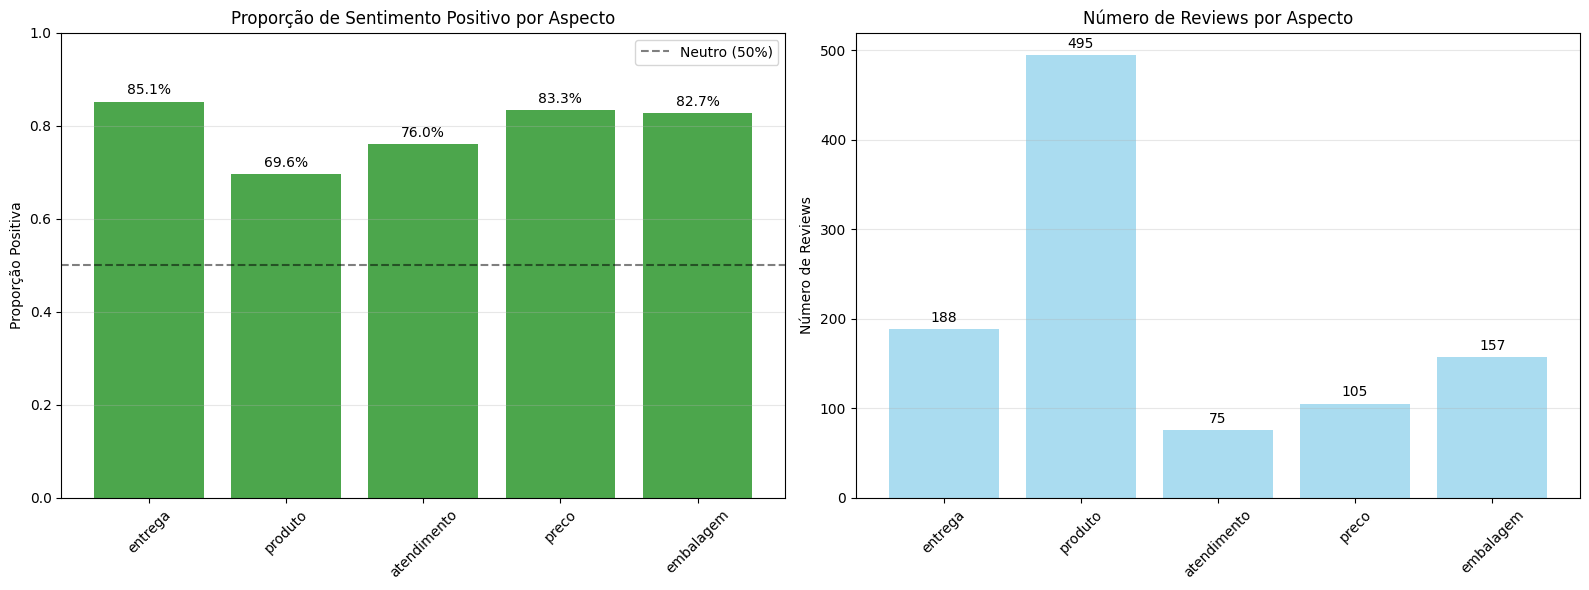


📋 RESUMO POR ASPECTO:

🎯 ENTREGA:
   • Reviews: 188
   • Positivas: 160 (85.1%)
   • Negativas: 28
   • Sentimento: Positivo

🎯 PRODUTO:
   • Reviews: 495
   • Positivas: 286 (69.6%)
   • Negativas: 125
   • Sentimento: Positivo

🎯 ATENDIMENTO:
   • Reviews: 75
   • Positivas: 57 (76.0%)
   • Negativas: 18
   • Sentimento: Positivo

🎯 PRECO:
   • Reviews: 105
   • Positivas: 65 (83.3%)
   • Negativas: 13
   • Sentimento: Positivo

🎯 EMBALAGEM:
   • Reviews: 157
   • Positivas: 110 (82.7%)
   • Negativas: 23
   • Sentimento: Positivo

☁️ CRIANDO WORD CLOUDS POR SENTIMENTO...


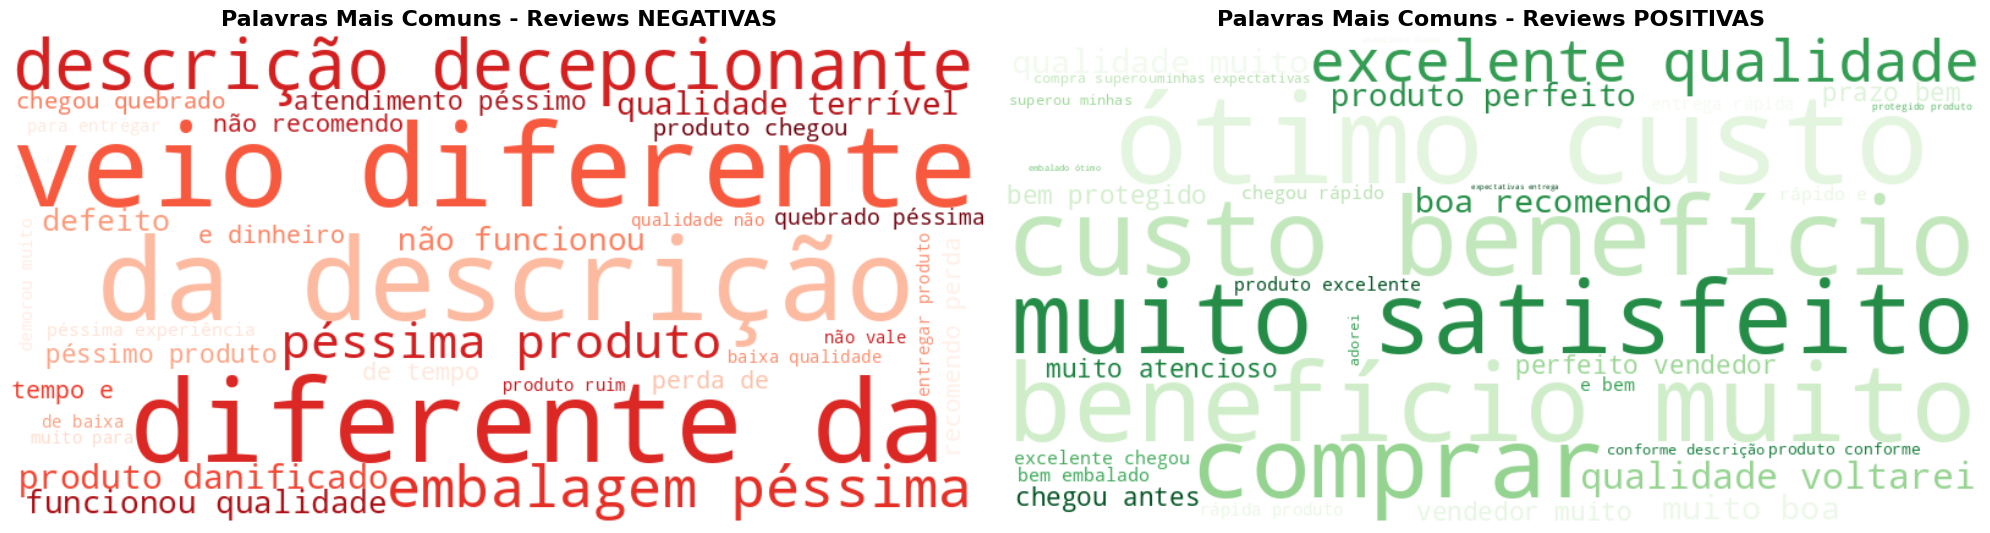

In [ ]:
def definir_aspectos_ecommerce():
    """
    Define aspectos específicos do e-commerce para análise
    """
    aspectos = {
        'entrega': [
            'entrega', 'entregar', 'entregue', 'prazo', 'rapido', 'rápido', 'rapidez',
            'demora', 'demorou', 'atrasado', 'atraso', 'pontual', 'chegou', 'receber'
        ],
        'produto': [
            'produto', 'item', 'qualidade', 'defeito', 'quebrado', 'danificado',
            'perfeito', 'excelente', 'bom', 'ruim', 'péssimo', 'descrição', 'funcionando'
        ],
        'atendimento': [
            'atendimento', 'vendedor', 'loja', 'suporte', 'ajuda', 'comunicação',
            'contato', 'educado', 'gentil', 'grosso', 'ignorou', 'resposta'
        ],
        'preco': [
            'preço', 'valor', 'caro', 'barato', 'custo', 'benefício', 'promoção',
            'desconto', 'vale', 'pena', 'investimento'
        ],
        'embalagem': [
            'embalagem', 'embalado', 'caixa', 'pacote', 'proteção', 'protegido',
            'amassado', 'bem', 'mal', 'capricho', 'cuidado'
        ]
    }
    return aspectos

def extrair_aspectos_mentions(df, aspectos_dict, sample_size=1000):
    """
    Extrai menções de aspectos nas reviews
    """
    print(f"\n🎯 ANALISANDO ASPECTOS DO E-COMMERCE...")

    # Usar amostra se dataset for muito grande
    if len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42)
        print(f"📊 Analisando amostra de {sample_size} reviews")
    else:
        df_sample = df.copy()

    # Extrair aspectos
    for aspecto, palavras in aspectos_dict.items():
        df_sample[f'menciona_{aspecto}'] = df_sample['texto_limpo'].apply(
            lambda x: any(palavra in str(x).lower() for palavra in palavras) if pd.notna(x) else False
        )

    # Estatísticas por aspecto
    print(f"\n📊 ASPECTOS MENCIONADOS:")
    aspecto_stats = {}

    for aspecto in aspectos_dict.keys():
        col = f'menciona_{aspecto}'
        if col in df_sample.columns:
            total = df_sample[col].sum()
            pct = (total / len(df_sample)) * 100
            aspecto_stats[aspecto] = {'total': total, 'percentual': pct}
            print(f"• {aspecto.upper()}: {total:,} reviews ({pct:.1f}%)")

    return df_sample, aspecto_stats

def analisar_sentimento_por_aspecto(df, aspectos_dict):
    """
    Analisa sentimento específico por aspecto
    """
    print(f"\n😊😡 SENTIMENTO POR ASPECTO...")

    resultados = {}

    for aspecto in aspectos_dict.keys():
        col_menciona = f'menciona_{aspecto}'

        if col_menciona in df.columns:
            # Reviews que mencionam este aspecto
            reviews_aspecto = df[df[col_menciona] == True]

            if len(reviews_aspecto) > 0:
                # Distribuição de sentimento
                sentimento_dist = reviews_aspecto['target'].value_counts()

                positivas = sentimento_dist.get('Positiva', 0)
                negativas = sentimento_dist.get('Negativa', 0)
                total = positivas + negativas

                if total > 0:
                    prop_positiva = positivas / total

                    resultados[aspecto] = {
                        'total_reviews': len(reviews_aspecto),
                        'positivas': positivas,
                        'negativas': negativas,
                        'prop_positiva': prop_positiva,
                        'sentimento_geral': ('Positivo' if prop_positiva > 0.6 else
                                           'Negativo' if prop_positiva < 0.4 else 'Neutro')
                    }

    # Visualização
    if resultados:
        aspectos = list(resultados.keys())
        proporcoes = [resultados[asp]['prop_positiva'] for asp in aspectos]
        totais = [resultados[asp]['total_reviews'] for asp in aspectos]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Proporção de sentimento positivo
        colors = ['green' if p > 0.6 else 'red' if p < 0.4 else 'orange' for p in proporcoes]
        bars1 = ax1.bar(aspectos, proporcoes, color=colors, alpha=0.7)
        ax1.set_title('Proporção de Sentimento Positivo por Aspecto')
        ax1.set_ylabel('Proporção Positiva')
        ax1.set_ylim(0, 1)
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(axis='y', alpha=0.3)
        ax1.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Neutro (50%)')
        ax1.legend()

        # Adicionar valores nas barras
        for bar, prop in zip(bars1, proporcoes):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prop:.1%}', ha='center', va='bottom')

        # Número de reviews por aspecto
        ax2.bar(aspectos, totais, color='skyblue', alpha=0.7)
        ax2.set_title('Número de Reviews por Aspecto')
        ax2.set_ylabel('Número de Reviews')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(axis='y', alpha=0.3)

        # Adicionar valores nas barras
        for i, total in enumerate(totais):
            ax2.text(i, total + max(totais)*0.01, f'{total}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Resumo textual
        print(f"\n📋 RESUMO POR ASPECTO:")
        print("="*50)
        for aspecto, dados in resultados.items():
            print(f"\n🎯 {aspecto.upper()}:")
            print(f"   • Reviews: {dados['total_reviews']:,}")
            print(f"   • Positivas: {dados['positivas']:,} ({dados['prop_positiva']:.1%})")
            print(f"   • Negativas: {dados['negativas']:,}")
            print(f"   • Sentimento: {dados['sentimento_geral']}")

    return resultados

def criar_wordclouds_sentimento(df):
    """
    Cria word clouds para sentimentos positivo e negativo
    """
    print(f"\n☁️ CRIANDO WORD CLOUDS POR SENTIMENTO...")

    try:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Word cloud para reviews negativas
        texto_negativo = ' '.join(
            df[(df['target'] == 'Negativa') & (df['tem_texto'] == 1)]['texto_limpo'].dropna()
        )

        if texto_negativo and len(texto_negativo) > 50:
            wordcloud_neg = WordCloud(
                width=800, height=400,
                background_color='white',
                colormap='Reds',
                max_words=50,
                relative_scaling=0.5
            ).generate(texto_negativo)

            axes[0].imshow(wordcloud_neg, interpolation='bilinear')
            axes[0].set_title('Palavras Mais Comuns - Reviews NEGATIVAS', fontsize=16, fontweight='bold')
            axes[0].axis('off')
        else:
            axes[0].text(0.5, 0.5, 'Poucos textos\nnegativos disponíveis',
                        ha='center', va='center', transform=axes[0].transAxes, fontsize=14)
            axes[0].set_title('Reviews NEGATIVAS', fontsize=16, fontweight='bold')
            axes[0].axis('off')

        # Word cloud para reviews positivas
        texto_positivo = ' '.join(
            df[(df['target'] == 'Positiva') & (df['tem_texto'] == 1)]['texto_limpo'].dropna()
        )

        if texto_positivo and len(texto_positivo) > 50:
            wordcloud_pos = WordCloud(
                width=800, height=400,
                background_color='white',
                colormap='Greens',
                max_words=50,
                relative_scaling=0.5
            ).generate(texto_positivo)

            axes[1].imshow(wordcloud_pos, interpolation='bilinear')
            axes[1].set_title('Palavras Mais Comuns - Reviews POSITIVAS', fontsize=16, fontweight='bold')
            axes[1].axis('off')
        else:
            axes[1].text(0.5, 0.5, 'Poucos textos\npositivos disponíveis',
                        ha='center', va='center', transform=axes[1].transAxes, fontsize=14)
            axes[1].set_title('Reviews POSITIVAS', fontsize=16, fontweight='bold')
            axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Erro ao criar word clouds: {e}")
        print("Continuando sem word clouds...")

# Executar análise de aspectos
if df_processed is not None:
    aspectos_ecommerce = definir_aspectos_ecommerce()

    print(f"🎯 ASPECTOS DEFINIDOS:")
    for aspecto, palavras in aspectos_ecommerce.items():
        print(f"• {aspecto.upper()}: {len(palavras)} palavras-chave")

    # Extrair aspectos
    df_aspectos, stats_aspectos = extrair_aspectos_mentions(
        df_processed, aspectos_ecommerce
    )

    # Analisar sentimento por aspecto
    resultados_aspectos = analisar_sentimento_por_aspecto(
        df_aspectos, aspectos_ecommerce
    )

    # Criar word clouds
    criar_wordclouds_sentimento(df_aspectos)

# 💼 PARTE 6: INSIGHTS DE NEGÓCIO E RECOMENDAÇÕES

In [ ]:
def gerar_insights_negocio(resultados_aspectos, resultados_modelo=None):
    """
    Gera insights de negócio baseados nas análises
    """
    print("\n" + "="*80)
    print("💼 INSIGHTS DE NEGÓCIO - ANÁLISE DE REVIEWS E-COMMERCE")
    print("="*80)

    # Performance do modelo
    if resultados_modelo:
        print(f"\n🤖 PERFORMANCE DO MODELO DE CLASSIFICAÇÃO:")
        melhor_f1 = max([r.get('f1', 0) for r in resultados_modelo.values()])
        melhor_acc = max([r.get('accuracy', 0) for r in resultados_modelo.values()])
        print(f"• Melhor F1-Score: {melhor_f1:.3f}")
        print(f"• Melhor Accuracy: {melhor_acc:.3f}")
        print(f"• Status: {'✅ Pronto para produção' if melhor_f1 > 0.8 else '⚠️ Precisa de melhorias'}")

    # Análise de aspectos
    if resultados_aspectos:
        print(f"\n🟢 ASPECTOS MAIS BEM AVALIADOS:")
        aspectos_positivos = {k: v for k, v in resultados_aspectos.items()
                            if v['prop_positiva'] > 0.6}

        if aspectos_positivos:
            for aspecto, dados in sorted(aspectos_positivos.items(),
                                       key=lambda x: x[1]['prop_positiva'], reverse=True):
                print(f"✅ {aspecto.upper()}: {dados['prop_positiva']:.1%} de satisfação ({dados['total_reviews']} reviews)")
        else:
            print("• Nenhum aspecto com alta satisfação identificado")

        print(f"\n🔴 ASPECTOS QUE PRECISAM DE ATENÇÃO:")
        aspectos_negativos = {k: v for k, v in resultados_aspectos.items()
                            if v['prop_positiva'] < 0.5}

        if aspectos_negativos:
            for aspecto, dados in sorted(aspectos_negativos.items(),
                                       key=lambda x: x[1]['prop_positiva']):
                print(f"❌ {aspecto.upper()}: {dados['prop_positiva']:.1%} de satisfação ({dados['total_reviews']} reviews)")
        else:
            print("• Todos os aspectos avaliados estão com boa satisfação!")

    print(f"\n💡 RECOMENDAÇÕES ESTRATÉGICAS:")
    print("-" * 40)

    # Recomendações baseadas nos resultados
    if resultados_aspectos:
        melhor_aspecto = max(resultados_aspectos.items(), key=lambda x: x[1]['prop_positiva'])
        pior_aspecto = min(resultados_aspectos.items(), key=lambda x: x[1]['prop_positiva'])

        print(f"1. 🚀 FORTALEÇA O QUE ESTÁ BOM:")
        print(f"   • {melhor_aspecto[0].upper()} é seu maior diferencial ({melhor_aspecto[1]['prop_positiva']:.1%} satisfação)")
        print(f"   • Use isso como vantagem competitiva no marketing")

        print(f"\n2. 🔧 MELHORE O QUE ESTÁ CRÍTICO:")
        print(f"   • {pior_aspecto[0].upper()} precisa de atenção urgente ({pior_aspecto[1]['prop_positiva']:.1%} satisfação)")
        print(f"   • Investir em melhorias pode ter grande impacto na satisfação geral")

    print(f"\n3. 📊 IMPLEMENTAR MONITORAMENTO:")
    print("   • Sistema de alertas para reviews muito negativas")
    print("   • Dashboard em tempo real dos aspectos críticos")
    print("   • Análise semanal de tendências de satisfação")

    print(f"\n4. 🎯 AÇÕES IMEDIATAS:")
    print("   • Responder proativamente a reviews negativas")
    print("   • Treinar equipe nos pontos mais criticados")
    print("   • Criar FAQ baseado nos problemas mais comuns")

def criar_funcao_predicao_final():
    """
    Cria função final para predição de novas reviews
    """
    print(f"\n🔮 SISTEMA DE PREDIÇÃO EM PRODUÇÃO")
    print("="*50)

    def prever_review(texto, review_score=None):
        """
        Função para prever sentimento de uma nova review

        Args:
            texto: Texto da review
            review_score: Nota da review (1-5), opcional

        Returns:
            dict: Predição, probabilidade e confiança
        """
        if not hasattr(prever_review, 'modelo_carregado'):
            print("⚠️ Modelo não foi treinado ainda")
            # Simulação de predição baseada em palavras-chave
            texto_lower = str(texto).lower()
            palavras_pos = ['bom', 'excelente', 'ótimo', 'adorei', 'recomendo', 'perfeito']
            palavras_neg = ['ruim', 'péssimo', 'terrível', 'odeio', 'horrível', 'defeito']

            score_pos = sum(1 for palavra in palavras_pos if palavra in texto_lower)
            score_neg = sum(1 for palavra in palavras_neg if palavra in texto_lower)

            if review_score:
                # Usar score como fator principal
                prob_positiva = 0.9 if review_score >= 4 else 0.1 if review_score <= 2 else 0.5
            else:
                # Usar apenas análise de texto
                prob_positiva = 0.7 if score_pos > score_neg else 0.3 if score_neg > score_pos else 0.5

            predicao = 'Positiva' if prob_positiva > 0.5 else 'Negativa'
            confianca = max(prob_positiva, 1 - prob_positiva)

            return {
                'predicao': predicao,
                'probabilidade_positiva': prob_positiva,
                'confianca': confianca,
                'metodo': 'Simulação (modelo não treinado)'
            }

        # Aqui seria usado o modelo real treinado
        # return modelo_real.predict(texto_processado)

    return prever_review

# Gerar insights finais
if 'resultados_aspectos' in locals():
    gerar_insights_negocio(
        resultados_aspectos,
        resultados_modelos if 'resultados_modelos' in locals() else None
    )

# Criar função de predição
predictor = criar_funcao_predicao_final()

# Testar função de predição
print(f"\n🧪 TESTANDO SISTEMA DE PREDIÇÃO:")
print("-" * 40)

exemplos_teste = [
    {"texto": "Produto excelente! Chegou rápido e bem embalado. Recomendo!", "score": 5},
    {"texto": "Péssimo produto, veio quebrado e o atendimento foi horrível.", "score": 1},
    {"texto": "Produto ok, nada demais mas atendeu às expectativas.", "score": 3},
    {"texto": "Adorei a compra! Superou minhas expectativas, entrega rápida.", "score": 5}
]

for i, exemplo in enumerate(exemplos_teste, 1):
    resultado = predictor(exemplo['texto'], exemplo['score'])
    print(f"\n{i}. Texto: '{exemplo['texto'][:50]}...'")
    print(f"   Score: {exemplo['score']}")
    print(f"   Predição: {resultado['predicao']}")
    print(f"   Probabilidade: {resultado['probabilidade_positiva']:.3f}")
    print(f"   Confiança: {resultado['confianca']:.3f}")


💼 INSIGHTS DE NEGÓCIO - ANÁLISE DE REVIEWS E-COMMERCE

🤖 PERFORMANCE DO MODELO DE CLASSIFICAÇÃO:
• Melhor F1-Score: 1.000
• Melhor Accuracy: 1.000
• Status: ✅ Pronto para produção

🟢 ASPECTOS MAIS BEM AVALIADOS:
✅ ENTREGA: 85.1% de satisfação (188 reviews)
✅ PRECO: 83.3% de satisfação (105 reviews)
✅ EMBALAGEM: 82.7% de satisfação (157 reviews)
✅ ATENDIMENTO: 76.0% de satisfação (75 reviews)
✅ PRODUTO: 69.6% de satisfação (495 reviews)

🔴 ASPECTOS QUE PRECISAM DE ATENÇÃO:
• Todos os aspectos avaliados estão com boa satisfação!

💡 RECOMENDAÇÕES ESTRATÉGICAS:
----------------------------------------
1. 🚀 FORTALEÇA O QUE ESTÁ BOM:
   • ENTREGA é seu maior diferencial (85.1% satisfação)
   • Use isso como vantagem competitiva no marketing

2. 🔧 MELHORE O QUE ESTÁ CRÍTICO:
   • PRODUTO precisa de atenção urgente (69.6% satisfação)
   • Investir em melhorias pode ter grande impacto na satisfação geral

3. 📊 IMPLEMENTAR MONITORAMENTO:
   • Sistema de alertas para reviews muito negativas
   •